In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =294

ng =7

nref =2

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 2 , 5 /) 

data wgt
     &     /0.5 , 0.6 , 0.7 , 0.8,
     &     0.9 , 0.95 , 0.95/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.75 , 1.75 , 1.75 , 1.75,
     &     1.75 , 1.75 , 1.9/

klin =2e-20

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

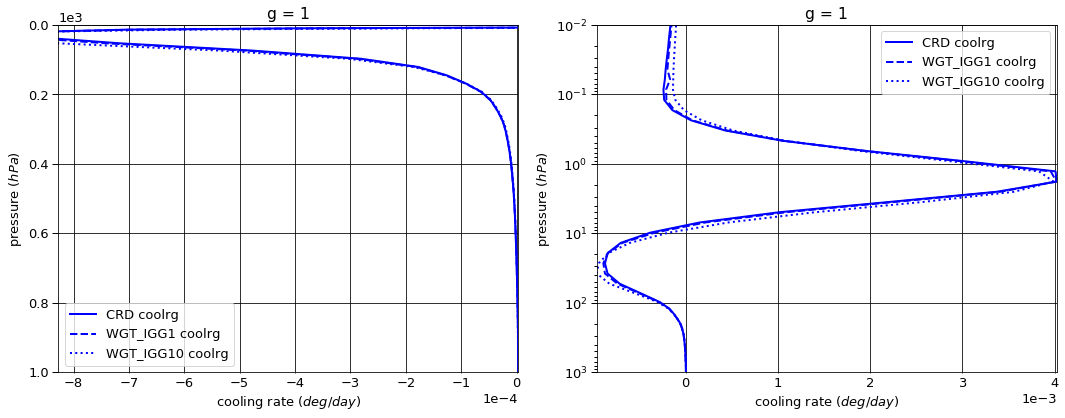

# Figure: cooling rate g-group 2

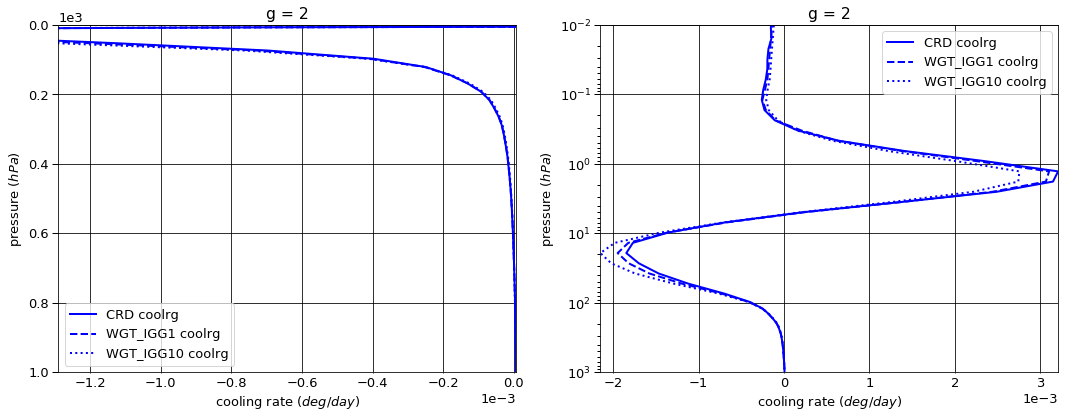

# Figure: cooling rate g-group 3

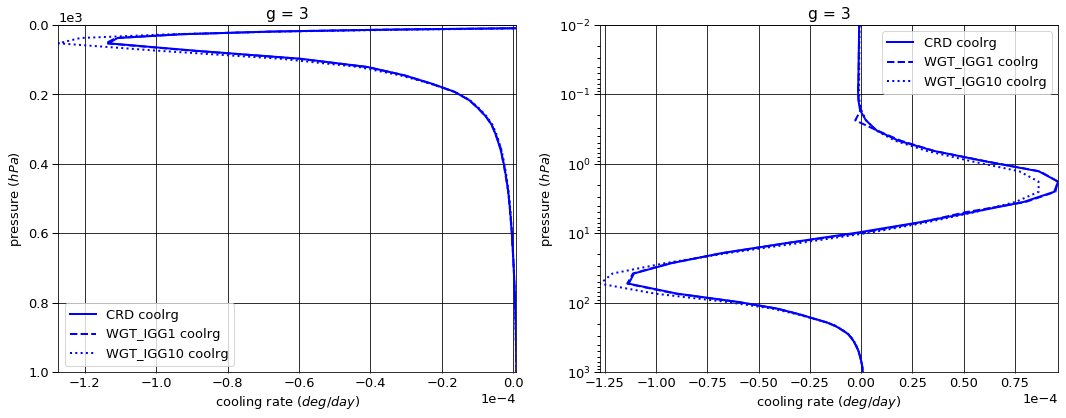

# Figure: cooling rate g-group 4

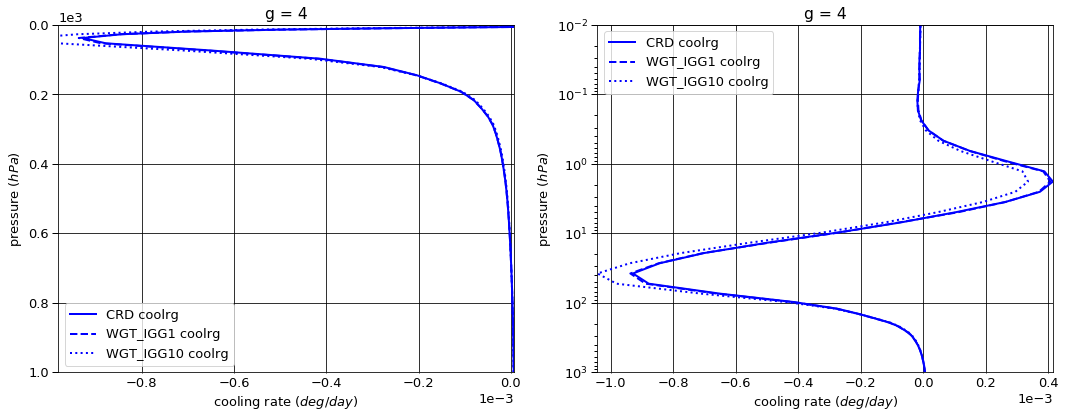

# Figure: cooling rate g-group 5

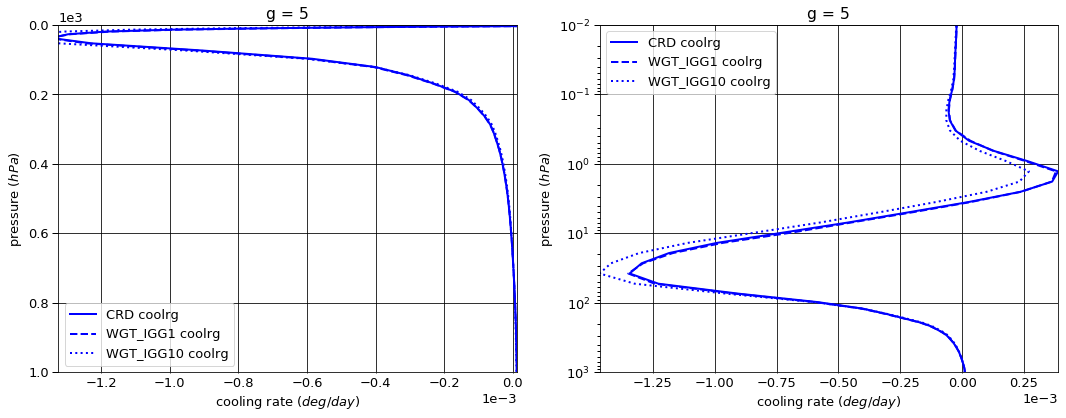

# Figure: cooling rate g-group 6

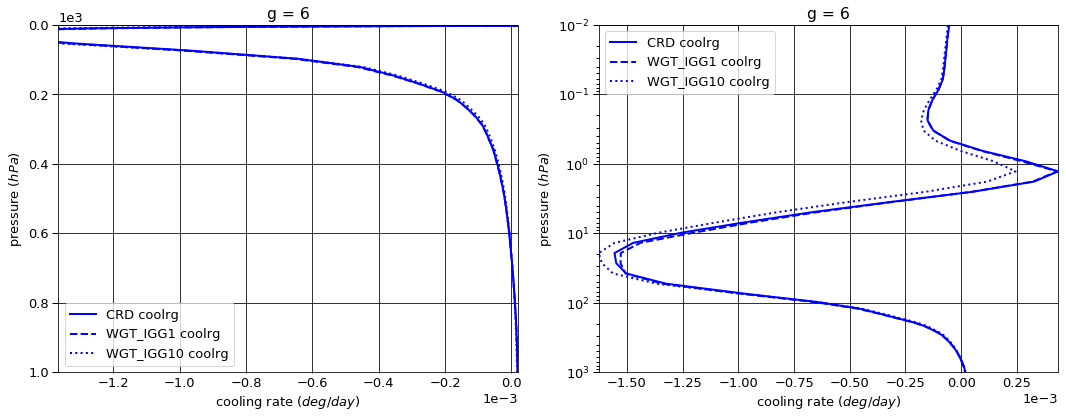

# Figure: cooling rate g-group 7

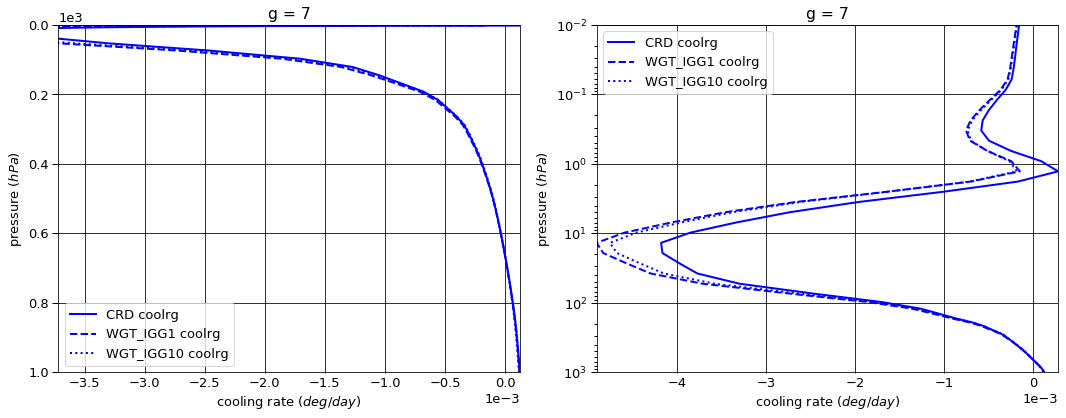

# Figure: cooling rate g-group total

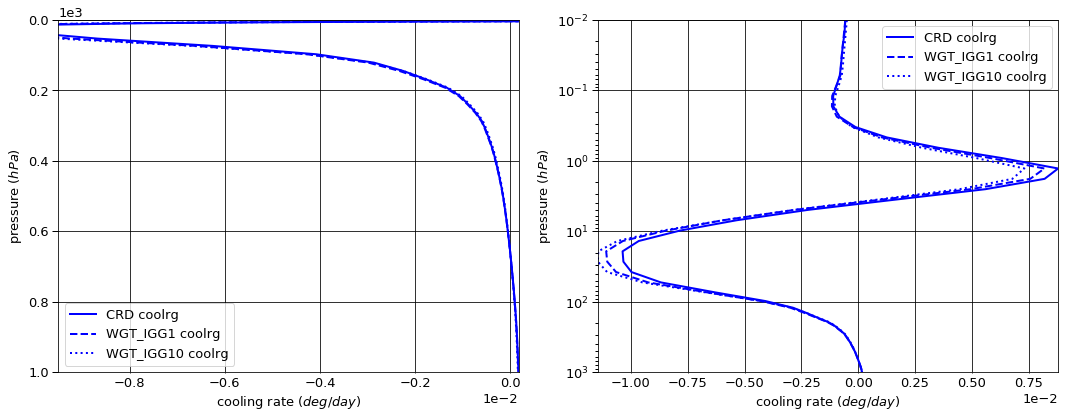

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002090  0.000000 -0.002090
  1013.0   76    -0.010094  0.000646 -0.009449
2 0.0      1     -0.008766  0.000000 -0.008766
  1013.0   76    -0.024450  0.001390 -0.023060
3 0.0      1     -0.000402  0.000000 -0.000402
  1013.0   76    -0.001942  0.000125 -0.001817
4 0.0      1     -0.006523  0.000000 -0.006523
  1013.0   76    -0.018477  0.000934 -0.017543
5 0.0      1     -0.022640  0.000000 -0.022640
  1013.0   76    -0.041029  0.001610 -0.039419
6 0.0      1     -0.054672  0.000000 -0.054672
  1013.0   76    -0.076984  0.002323 -0.074661
7 0.0      1     -6.386176  0.000000 -6.386176
  1013.0   76    -6.452477  0.010389 -6.442088


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001975  0.000000 -0.001975
  1013.0   76    -0.010094  0.000643 -0.009452
2 0.0      1     -0.008052  0.000000 -0.008052
  1013.0   76    -0.024450  0.001411 -0.023040
3 0.0      1     -0.000396  0.000000 -0.000396
  1013.0   76    -0.001942  0.000125 -0.001817
4 0.0      1     -0.006433  0.000000 -0.006433
  1013.0   76    -0.018477  0.000937 -0.017540
5 0.0      1     -0.022541  0.000000 -0.022541
  1013.0   76    -0.041029  0.001611 -0.039418
6 0.0      1     -0.054584  0.000000 -0.054584
  1013.0   76    -0.076984  0.002323 -0.074661
7 0.0      1     -6.379792  0.000000 -6.379792
  1013.0   76    -6.452477  0.010424 -6.442052


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001779  0.000000 -0.001779
  1013.0   76    -0.010094  0.000602 -0.009492
2 0.0      1     -0.006978  0.000000 -0.006978
  1013.0   76    -0.024450  0.001434 -0.023017
3 0.0      1     -0.000312  0.000000 -0.000312
  1013.0   76    -0.001942  0.000121 -0.001820
4 0.0      1     -0.005687  0.000000 -0.005687
  1013.0   76    -0.018477  0.000928 -0.017549
5 0.0      1     -0.021833  0.000000 -0.021833
  1013.0   76    -0.041029  0.001576 -0.039453
6 0.0      1     -0.054528  0.000000 -0.054528
  1013.0   76    -0.076984  0.002223 -0.074761
7 0.0      1     -6.382534  0.000000 -6.382534
  1013.0   76    -6.452477  0.009998 -6.442479


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      1.145626e-04  0.000000e+00  1.145626e-04
  1013.0   76    -1.734723e-18 -3.312040e-06 -3.312100e-06
2 0.0      1      7.144520e-04  0.000000e+00  7.144520e-04
  1013.0   76     0.000000e+00  2.050150e-05  2.050200e-05
3 0.0      1      6.192960e-06  0.000000e+00  6.192960e-06
  1013.0   76     0.000000e+00  3.712000e-08  3.710000e-08
4 0.0      1      9.039850e-05  0.000000e+00  9.039850e-05
  1013.0   76     0.000000e+00  2.953800e-06  2.954000e-06
5 0.0      1      9.935000e-05  0.000000e+00  9.935000e-05
  1013.0   76     0.000000e+00  1.055400e-06  1.055000e-06
6 0.0      1      8.788900e-05  0.000000e+00  8.788900e-05
  1013.0   76     0.000000e+00  6.550000e-08  6.600000e-08
7 0.0      1      6.384600e-03  0.000000e+00  6.384600e-03
  1013.0   76     0.000000e+00  3.498300e-05  3.500000e-05


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.109180e-04  0.000000  0.000311
  1013.0   76    -1.734723e-18 -0.000044 -0.000044
2 0.0      1      1.788321e-03  0.000000  0.001788
  1013.0   76     0.000000e+00  0.000043  0.000043
3 0.0      1      8.968769e-05  0.000000  0.000090
  1013.0   76     0.000000e+00 -0.000004 -0.000004
4 0.0      1      8.358209e-04  0.000000  0.000836
  1013.0   76     0.000000e+00 -0.000006 -0.000006
5 0.0      1      8.068900e-04  0.000000  0.000807
  1013.0   76     0.000000e+00 -0.000034 -0.000034
6 0.0      1      1.432470e-04  0.000000  0.000143
  1013.0   76     0.000000e+00 -0.000100 -0.000100
7 0.0      1      3.642600e-03  0.000000  0.003643
  1013.0   76     0.000000e+00 -0.000391 -0.000391

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.977156e-05
  1001.112500 75     3.292908e-06
2 0.000312    1     -5.214849e-05
  1001.112500 75     6.148333e-06
3 0.000312    1     -3.112521e-07
  1001.112500 75     8.703670e-07
4 0.000312    1     -2.884060e-06
  1001.112500 75     6.096847e-06
5 0.000312    1     -7.205011e-06
  1001.112500 75     1.164157e-05
6 0.000312    1     -1.788443e-05
  1001.112500 75     1.886244e-05
7 0.000312    1     -5.174985e-05
  1001.112500 75     1.233152e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -5.479885e-05
  1001.112500 75     3.283701e-06
2 0.000312    1     -4.741268e-05
  1001.112500 75     6.093141e-06
3 0.000312    1     -2.969881e-07
  1001.112500 75     8.734916e-07
4 0.000312    1     -2.691650e-06
  1001.112500 75     6.092299e-06
5 0.000312    1     -7.069474e-06
  1001.112500 75     1.161153e-05
6 0.000312    1     -1.821021e-05
  1001.112500 75     1.893266e-05
7 0.000312    1     -6.132851e-05
  1001.112500 75     1.204706e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -3.776706e-05
  1001.112500 75     2.993425e-06
2 0.000312    1     -4.094578e-05
  1001.112500 75     5.485751e-06
3 0.000312    1     -2.387767e-07
  1001.112500 75     7.955544e-07
4 0.000312    1     -2.682464e-06
  1001.112500 75     5.543658e-06
5 0.000312    1     -7.670212e-06
  1001.112500 75     1.054327e-05
6 0.000312    1     -1.946157e-05
  1001.112500 75     1.704013e-05
7 0.000312    1     -5.945757e-05
  1001.112500 75     1.152641e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.972717e-06
  1001.112500 75    -9.207600e-09
2 0.000312    1      4.735811e-06
  1001.112500 75    -5.519190e-08
3 0.000312    1      1.426399e-08
  1001.112500 75     3.124520e-09
4 0.000312    1      1.924108e-07
  1001.112500 75    -4.547700e-09
5 0.000312    1      1.355370e-07
  1001.112500 75    -3.004000e-08
6 0.000312    1     -3.257780e-07
  1001.112500 75     7.022000e-08
7 0.000312    1     -9.578663e-06
  1001.112500 75    -2.844650e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.200450e-05
  1001.112500 75    -2.994836e-07
2 0.000312    1      1.120271e-05
  1001.112500 75    -6.625822e-07
3 0.000312    1      7.247542e-08
  1001.112500 75    -7.481264e-08
4 0.000312    1      2.015961e-07
  1001.112500 75    -5.531882e-07
5 0.000312    1     -4.652012e-07
  1001.112500 75    -1.098306e-06
6 0.000312    1     -1.577144e-06
  1001.112500 75    -1.822318e-06
7 0.000312    1     -7.707721e-06
  1001.112500 75    -8.051140e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.481269,0.000000,-6.481269
1013.0,76,-6.625452,0.017417,-6.608036



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.473771,0.000000,-6.473771
1013.0,76,-6.625452,0.017473,-6.607979



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.473651,0.000000,-6.473651
1013.0,76,-6.625452,0.016881,-6.608571



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.007497,0.000000,0.007497
1013.0,76,0.000000,0.000056,0.000056



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.007617,0.000000,0.007617
1013.0,76,0.000000,-0.000535,-0.000535


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000192
1001.112500,75,0.000170



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000192
1001.112500,75,0.000167



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000168
1001.112500,75,0.000158



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,1.462988e-07
1001.112500,75,-2.870293e-06



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000024
1001.112500,75,-0.000013


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000791,0.001562
2,0.001895,0.003794
3,0.000155,0.000299
4,0.001450,0.002858
5,0.003195,0.006359
6,0.005945,0.011958
7,0.986568,0.973170


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.170995e-19
2,1.046602e-19
3,1.656130e-19
4,8.186633e-20
5,4.046841e-20
6,2.000446e-20
7,1.234195e-27


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.170995e-19,NaN,0.000791,0.001562,0.000791,0.001562,1.0
2,1.046602e-19,2.509238e-01,0.001895,0.003794,0.002686,0.005356,1.0
3,1.656130e-19,1.582388e+00,0.000155,0.000299,0.002841,0.005655,50.0
4,8.186633e-20,4.943230e-01,0.001450,0.002858,0.004291,0.008513,50.0
5,4.046841e-20,4.943230e-01,0.003195,0.006359,0.007486,0.014872,50.0
6,2.000446e-20,4.943230e-01,0.005945,0.011958,0.013432,0.026830,50.0
7,1.234195e-27,6.169600e-08,0.986568,0.973170,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog          ratio        taulyr
layer g pressure                                                            
1     1 0.000312     8.091764e-19  7.241473e-19       1.117420  1.098456e-06
      2 0.000312     2.122232e-19  1.699697e-19       1.248595  2.798528e-07
      3 0.000312     2.854314e-20  2.726386e-20       1.046922  4.034610e-08
      4 0.000312     1.600228e-20  1.369380e-20       1.168578  2.226621e-08
      5 0.000312     1.143363e-20  7.441697e-21       1.536428  1.580990e-08
      6 0.000312     1.132325e-20  5.565041e-21       2.034712  1.581120e-08
      7 0.000312     2.752769e-22  1.695570e-27  162350.630000  3.746902e-10
2     1 0.000750     8.083668e-19  7.237066e-19       1.116982  4.958328e-07
      2 0.000750     2.122824e-19  1.701091e-19       1.247919  1.264851e-07
      3 0.000750     2.862895e-20  2.734473e-20       1.046964  1.828130e-08
      4 0.000750     1.604662e-20  1.372984e-20       1.168741  1.008659e-08
      5 0.000750     1.145792e-20  7.455828e-21       1.536773  7.157327e-09
      6 0.000750     1.134172e-20  5.573125e-21       2.035074  7.154469e-09
      7 0.000750     2.758609e-22  1.748858e-27  157737.700000  1.696288e-10
3     1 0.001052     8.066696e-19  7.227813e-19       1.116063  8.443123e-07
      2 0.001052     2.124083e-19  1.704031e-19       1.246505  2.159635e-07
      3 0.001052     2.880230e-20  2.750776e-20       1.047061  3.137105e-08
      4 0.001052     1.613655e-20  1.380233e-20       1.169118  1.730049e-08
      5 0.001052     1.150814e-20  7.484458e-21       1.537605  1.226158e-08
      6 0.001052     1.138065e-20  5.589745e-21       2.035987  1.224538e-08
      7 0.001052     2.770994e-22  1.780724e-27  155610.550000  2.906410e-10
4     1 0.001476     8.048705e-19  7.217925e-19       1.115100  1.394035e-06
      2 0.001476     2.125397e-19  1.707121e-19       1.245018  3.575959e-07
      3 0.001476     2.898753e-20  2.768202e-20       1.047161  5.222326e-08
      4 0.001476     1.623262e-20  1.387983e-20       1.169512  2.878549e-08
      5 0.001476     1.156163e-20  7.515008e-21       1.538471  2.037542e-08
      6 0.001476     1.142198e-20  5.607419e-21       2.036941  2.032847e-08
      7 0.001476     2.784189e-22  1.820349e-27  152948.080000  4.830399e-10
5     1 0.002070     8.030654e-19  7.207919e-19       1.114143  2.249419e-06
      2 0.002070     2.126691e-19  1.710191e-19       1.243540  5.786717e-07
      3 0.002070     2.917556e-20  2.785899e-20       1.047259  8.496808e-08
      4 0.002070     1.633010e-20  1.395860e-20       1.169895  4.681061e-08
      5 0.002070     1.161562e-20  7.545972e-21       1.539314  3.309099e-08
      6 0.002070     1.146351e-20  5.625243e-21       2.037869  3.298156e-08
      7 0.002070     2.797487e-22  1.867035e-27  149835.860000  7.845994e-10
6     1 0.002904     8.012536e-19  7.197787e-19       1.113194  3.569239e-06
      2 0.002904     2.127960e-19  1.713238e-19       1.242069  9.208351e-07
      3 0.002904     2.936717e-20  2.803944e-20       1.047352  1.359560e-07
      4 0.002904     1.642936e-20  1.403900e-20       1.170266  7.486223e-08
      5 0.002904     1.167023e-20  7.577469e-21       1.540122  5.284968e-08
      6 0.002904     1.150523e-20  5.643260e-21       2.038755  5.262053e-08
      7 0.002904     2.810885e-22  1.922481e-27  146211.310000  1.253239e-09
7     1 0.004074     7.994323e-19  7.187510e-19       1.112252  5.587810e-06
      2 0.004074     2.129202e-19  1.716261e-19       1.240605  1.445755e-06
      3 0.004074     2.956366e-20  2.822465e-20       1.047441  2.146664e-07
      4 0.004074     1.653102e-20  1.412162e-20       1.170618  1.181406e-07
      5 0.004074     1.172565e-20  7.609711e-21       1.540880  8.328482e-08
      6 0.004074     1.154718e-20  5.661551e-21       2.039579  8.283462e-08
      7 0.004074     2.824389e-22  1.988507e-27  142035.690000  1.975130e-09
8     1 0.005714     7.975973e-19  7.177055e-19       1.111316  8.653261e-06
      2 0.005714     2

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
